In [1]:
# %pip install nltk

In [28]:
# !pip install -U yellowbrick

Requirement already up-to-date: yellowbrick in /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages (1.1)


In [3]:
import sys
import pandas as pd
import re
import nltk
from operator import add
from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover
import pyspark.sql.functions as f
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
# from nltk.corpus import stopwords


In [4]:
spark = SparkSession\
  .builder \
  .appName("PythonWordCount") \
  .getOrCreate()


# Read CSV from OVHcloud Object Storage https://github.com/walkerkq/musiclyrics
data = spark.read.format('json').options(header='true', inferSchema='true') \
  .load('country_romance_lyrics.json', sep=",", header=True) \

print('############ JSON extract:')
data.show()


############ JSON extract:
+----------------+--------------------+--------------------+----------+
|          Artist|              Lyrics|               Title|      Year|
+----------------+--------------------+--------------------+----------+
|Billy Currington|[Verse 1]
There's...|    Let Me Down Easy|2010-01-01|
|   Blake Shelton|[Verse 1]
She lik...|Doin' What She Likes|2013-03-26|
|Billy Currington|[Verse 1]
I don't...|     I Got A Feelin'|2011-01-01|
|   Blake Shelton|[Verse 1]
Girl, I...|           Honey Bee|2011-07-11|
|     Josh Turner|[Verse 1]
Baby wh...|Why Don't We Just...|      2010|
|      David Nail|[Verse 1]
She's a...|  Whatever She's Got|2013-01-01|
|  Brett Eldredge|[Verse 1]
Well I ...|   Beat of the Music|2013-08-06|
|Billy Currington|[Verse 1-Billy Cu...|            Hey Girl|2013-01-01|
| Scotty McCreery|[Verse 1]
Girl, y...|     See You Tonight|2013-01-01|
|     Chris Young|[Verse 1]
The blu...|                 You|2011-07-11|
|  Brett Eldredge|[Verse 1]
Girl yo..

In [5]:
# Tokenize DataFrame
data = Tokenizer(inputCol="Lyrics", outputCol="Words")

In [6]:
df=pd.read_json ('country_romance_lyrics.json',)

In [7]:
df.Lyrics=df.Lyrics.replace('\n', ' ')


df.head()

,Title,Artist,Year,Lyrics
0,Let Me Down Easy,Billy Currington,2010-01-01,"[Verse 1]\nThere's a little moonlight, dancing..."
1,Doin' What She Likes,Blake Shelton,2013-03-26,[Verse 1]\nShe likes it when I call in sick to...
2,I Got A Feelin',Billy Currington,2011-01-01,[Verse 1]\nI don't want to rush this thing\nI ...
3,Honey Bee,Blake Shelton,2011-07-11,"[Verse 1]\nGirl, I been thinking 'bout us\nAnd..."
4,Why Don't We Just Dance,Josh Turner,2010,[Verse 1]\nBaby why don't we just turn that TV...


In [8]:
df.Lyrics=df.Lyrics.str.lower()

df.head()

,Title,Artist,Year,Lyrics
0,Let Me Down Easy,Billy Currington,2010-01-01,"[verse 1]\nthere's a little moonlight, dancing..."
1,Doin' What She Likes,Blake Shelton,2013-03-26,[verse 1]\nshe likes it when i call in sick to...
2,I Got A Feelin',Billy Currington,2011-01-01,[verse 1]\ni don't want to rush this thing\ni ...
3,Honey Bee,Blake Shelton,2011-07-11,"[verse 1]\ngirl, i been thinking 'bout us\nand..."
4,Why Don't We Just Dance,Josh Turner,2010,[verse 1]\nbaby why don't we just turn that tv...


In [9]:
s = '[verse 1]\n'
# df.Lyrics=df.Lyrics.lstrip('[verse 1]\n')
df.Lyrics=df.Lyrics.map(lambda x: x.lstrip(s))

In [10]:
import nltk
from nltk.corpus import stopwords
# print(stopwords.words('english'))

In [11]:
df.Lyrics=df.Lyrics.apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

In [12]:
def identify_tokens(row):
    review = row['Lyrics']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

df['Lyrics'] = df.apply(identify_tokens, axis=1)

In [42]:
stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['Lyrics']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)



df['Lyrics'] = df.apply(remove_stops, axis=1)

In [63]:
stops = set(['chorus', 'verse', 'de', 'na', 'ne'])                 

def remove_stops(row):
    my_list = row['Lyrics']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)



df['Lyrics'] = df.apply(remove_stops, axis=1)

In [64]:

# Let's evaluate the POS tags for our test set data
tagged_stanzas_test = []
tagged_test = []

for word in df['Lyrics']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_test.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_test.append(tagged_stanzas_test)

In [65]:
# Let's evaluate the POS tags for our train set data
tagged_stanzas_train = []
tagged_train = []

for word in df['Lyrics']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_train.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_train.append(tagged_stanzas_train)

In [66]:
from yellowbrick.text import PosTagVisualizer
%matplotlib inline
from matplotlib import pyplot as plt

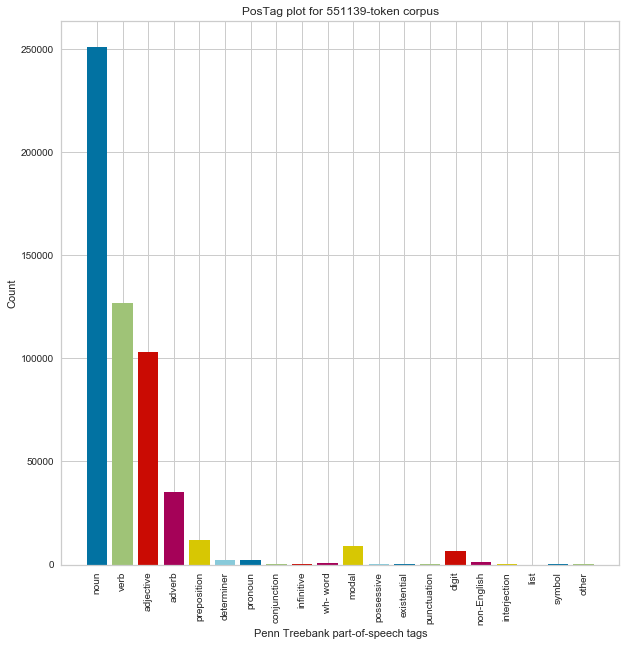

In [67]:
plt.figure(figsize=(10,10))
viz = PosTagVisualizer()
viz.fit(tagged_train)
viz.show()

In [68]:
# df['Lyrics'] = df['Lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# df.Lyrics.head()

In [75]:
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    # new= text.str.split()
    new=text
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

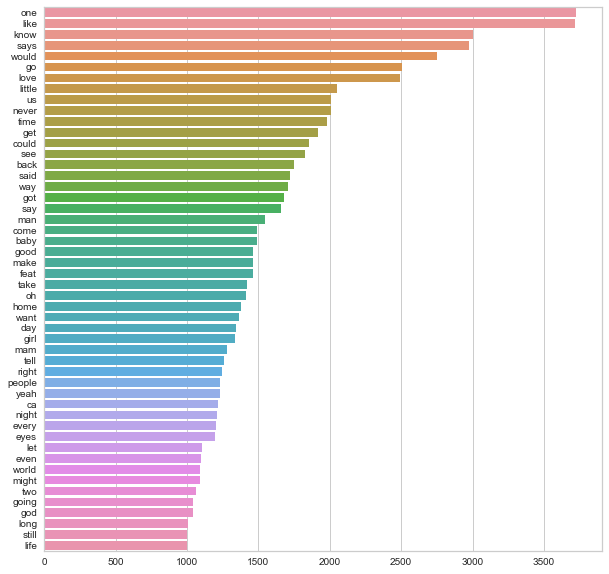

In [76]:
plot_top_non_stopwords_barchart(df['Lyrics'])

In [69]:
df.Lyrics.to_csv(
    'country.csv', index=True
)

In [70]:
data = spark.read.format('csv').options(header='true', inferSchema='true') \
  .load('country.csv') \
    

In [71]:
data.show()

+---+--------------------+
|_c0|              Lyrics|
+---+--------------------+
|  0|['little', 'moonl...|
|  1|['likes', 'call',...|
|  2|['want', 'rush', ...|
|  3|['girl', 'thinkin...|
|  4|['baby', 'turn', ...|
|  5|['little', 'compl...|
|  6|['well', 'met', '...|
|  7|['billy', 'currin...|
|  8|['girl', 'know', ...|
|  9|['bluest', 'skies...|
| 10|['girl', 'cut', '...|
| 11|['might', 'way', ...|
| 12|['time', 'kiss', ...|
| 13|['click', 'read',...|
| 14|['intro', 'first'...|
| 15|['could', 'reason...|
| 16|['baby', 'lock', ...|
| 17|['girl', 'way', '...|
| 18|['hit', 'door', '...|
| 19|['eyes', 'high', ...|
+---+--------------------+
only showing top 20 rows



In [72]:
data.withColumn('word', f.explode(f.split(f.col('Lyrics'), ' '))) \
  .groupBy('word') \
  .count() \
  .sort('count', ascending=False) \
  .show()


+---------+-----+
|     word|count|
+---------+-----+
|   'one',| 3708|
|  'like',| 3695|
|  'know',| 2982|
|  'says',| 2974|
| 'would',| 2749|
|    'go',| 2502|
|  'love',| 2461|
|'little',| 2047|
|    'us',| 2007|
| 'never',| 1995|
|  'time',| 1971|
|   'get',| 1914|
| 'could',| 1847|
|   'see',| 1820|
|  'back',| 1743|
|  'said',| 1714|
|   'way',| 1694|
|   'got',| 1655|
|   'say',| 1648|
|   'man',| 1536|
+---------+-----+
only showing top 20 rows

